###  **1、精度评价因子**

In [1]:
import torch
import numpy as np
def eval_metrics(pred,label,device):
    if device.type=="cuda":
        pred = pred.cpu()
        label = label.cpu()
    pred = pred.detach().numpy().flatten()
    label = label.detach().numpy().flatten()
    
    pred[pred>=0.5]=1
    pred[pred<0.5]=0
    #确保标签上的值能和预测的匹配上
    label[label>=0.5]=1
    label[label<0.5]=0
    N = label.shape[0]

    TP = ((pred == 1) & (label == 1)).sum()
    FP = ((pred == 1) & (label == 0)).sum()
    FN = ((pred == 0) & (label == 1)).sum()
    TN = ((pred == 0) & (label == 0)).sum()

    accuracy = round((pred==label).sum()/N,4)
    OA = 0.0 if (TP+FP+FN+TN)==0 else round((TP+TN)/(TP+FP+FN+TN),4)
    Pr = 0.0 if (TP+FP)==0 else round(TP/(TP+FP),4)
    Rc = 0.0 if (TP+FN) ==0 else round(TP/(TP+FN),4)
    F1 = 0.0 if (Pr+Rc)==0 else round(2*(Pr*Rc)/(Pr+Rc),4)
    IoU = 0.0 if (TP+FP+FN)==0 else round((TP)/(TP+FP+FN),4)
    
    return (OA,Pr,Rc,F1,IoU)

C:\Users\windows\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- 1> 模型初始化

In [2]:
# 模型参数初始化
import torch.nn as nn
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


- 2> U-Net模型定义

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x
    
class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        initialize_weights(self)

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)
        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = torch.sigmoid(d1)
        return d1

- **获取模型的参数量**

In [4]:
def get_parameter_number(model):
    total_num = sum(p.numel() for p in model.parameters())
    trainable_num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {'Total': total_num, 'Trainable': trainable_num}
unet = U_Net()
get_parameter_number(unet)

{'Total': 34527041, 'Trainable': 34527041}

### **3、定义训练图像生成器**

#### 3.1 **预先采样好的图片，从文件中取样本和标签**

In [5]:
# 训练图像分割的生成器
from torch.utils.data import Dataset
import torchvision
import torch
from skimage import io
import os
totensor = torchvision.transforms.ToTensor()
#  imageDataRoot路径应该直接指向一张完整的tif影像
#  labelDataRoot路径应该直接指向一张完整的tif标签

class SegImageDataset(Dataset):
    def __init__(self, imageDataRoot,labelDataRoot):
        self.img_paths_folder = imageDataRoot
        self.label_paths_folder = labelDataRoot

        self.img_paths = [] # 图像文件的路径
        self.label_paths = [] # 图像对应的标签

        self.folders =  os.listdir(self.img_paths_folder)
        for folder in self.folders:
            self.img_paths.append(os.path.join(self.img_paths_folder, folder))
            self.label_paths.append(os.path.join(self.label_paths_folder, folder))


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self,index):
        img_path = self.img_paths[index]
        label_path = self.label_paths[index]

        img = io.imread(img_path)
        label = io.imread(label_path)
        label = label.reshape(1,label.shape[0],label.shape[1])
        # 转图片格式
        img = totensor(img)
        label = torch.Tensor(label)
        return (img,label)

e:\anaconda3\install_path\envs\ddpm-cd\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 3.2 **图像增强**

In [6]:
from torchvision import transforms as transforms
import random
def augment(images,labels):
    rand_v = random.randint(0,9)
    # 水平翻转
    if (rand_v == 0):
        images = transforms.RandomHorizontalFlip(p=1)(images)
        labels = transforms.RandomHorizontalFlip(p=1)(labels)
    # 垂直翻转
    if (rand_v == 1):
        images = transforms.RandomVerticalFlip(p=1)(images)
        labels = transforms.RandomVerticalFlip(p=1)(labels)
    # 对角翻转
    if (rand_v == 2):
        images = transforms.RandomHorizontalFlip(p=1)(images)
        labels = transforms.RandomHorizontalFlip(p=1)(labels)
        images = transforms.RandomVerticalFlip(p=1)(images)
        labels = transforms.RandomVerticalFlip(p=1)(labels)
#     # 灰度变换
#     if random.random() > 0.75:
#         images = transforms.Grayscale()(images)
    # 随机旋转
    if (rand_v == 3) | (rand_v == 4):
        degrees = random.randint(0,360)
        images = transforms.RandomRotation([degrees,degrees])(images)
        labels = transforms.RandomRotation([degrees,degrees])(labels)
    # 高斯模糊
    # if random.random() > 0.5:
    #     images = transforms.GaussianBlur(kernel_size=(3, 3), sigma=random.randint(3,7))(images)
    # 亮度、对比度和饱和度调节
    # if random.random() > 0.5:
    #     random1 = random.randint(50,100)/100
    #     random2 = random.randint(50,100)/100
    #     random3 = random.randint(50,100)/100
    #     images = transforms.ColorJitter(brightness=random1, contrast=random2, saturation=random3)(images)
    return (images,labels)

### **4、检查图像生成器效果**

- **`samplePath` 样本rgb的路径**
- **`labelPath` 标签的路径**

In [6]:
# 路径中一定不成出现中文，否则tif文件打不开
samplePath = "./dataset/Sample/rgb/"
labelPath = "./dataset/Sample/label/"
ImageDataset =  SegImageDataset(samplePath, labelPath)
train_loader = torch.utils.data.DataLoader(
        ImageDataset,
        batch_size=6,
        shuffle=True,
        pin_memory=True)

#### 4.1 **预览`train_loader`的效果**

torch.Size([6, 3, 256, 256]) torch.Size([6, 1, 256, 256])


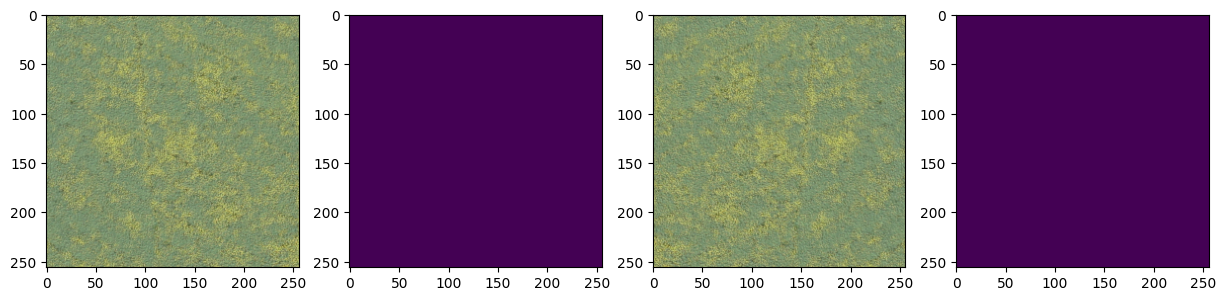

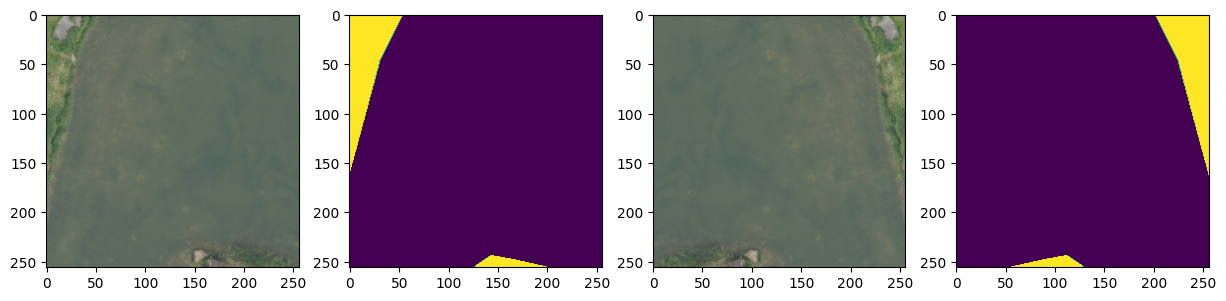

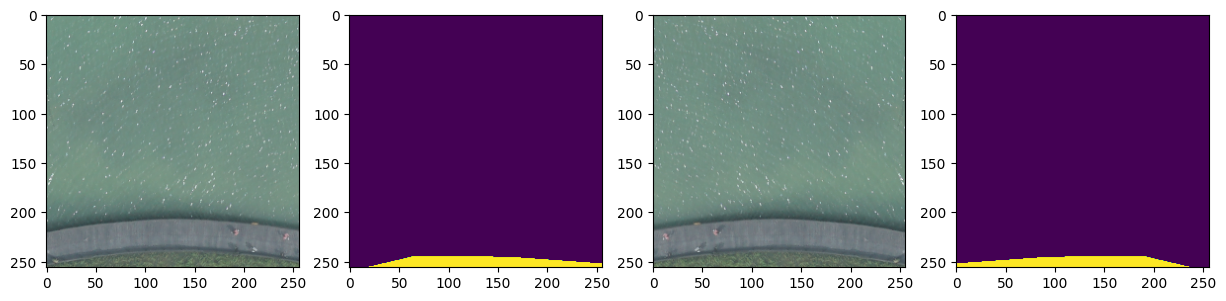

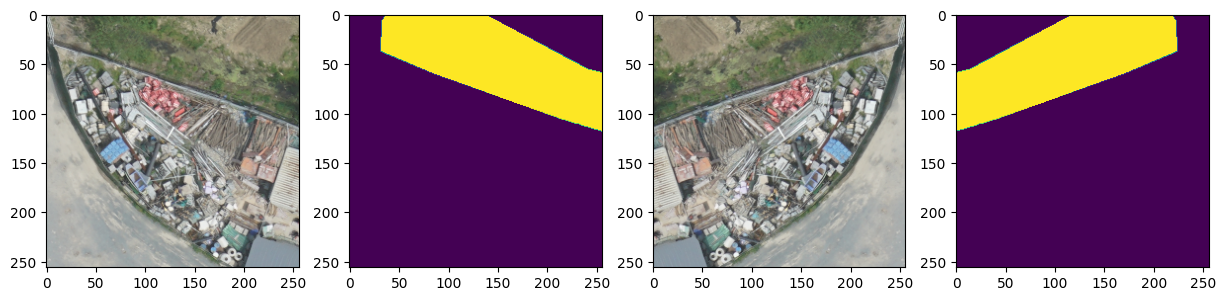

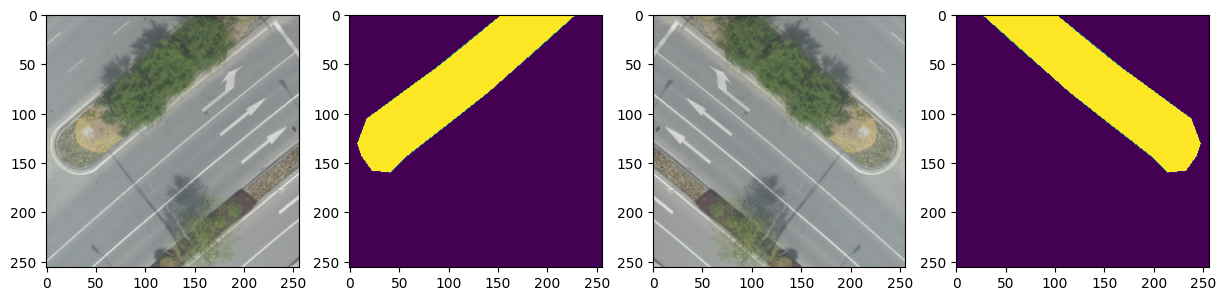

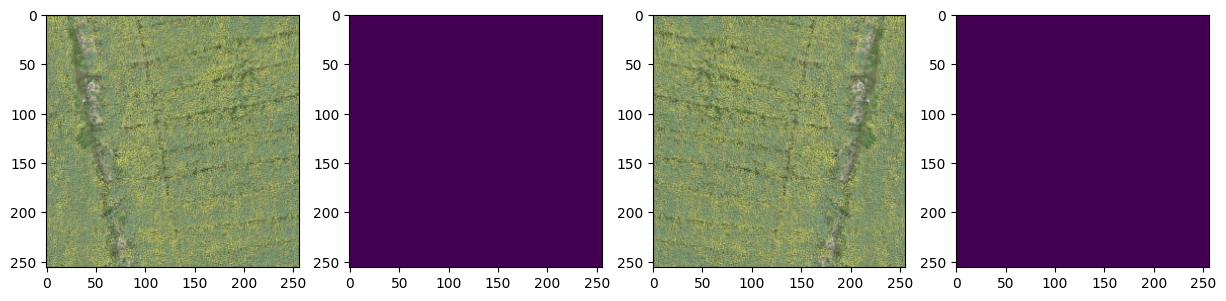

In [8]:
import numpy as np
import matplotlib.pyplot as plt

for i, (images, labels) in enumerate(train_loader):
    if i == 1:
        break
    new_images,new_labels = augment(images,labels)
    print(images.shape,labels.shape)
    for index in range(images.shape[0]):
        plt.figure(figsize=(15,15))
        plt.subplot(1, 4, 1)
        plt.imshow(np.transpose(images[index], (1,2,0)))# 把channel那一维放到最后
        plt.subplot(1, 4, 2)
        plt.imshow(np.transpose(labels[index], (1,2,0)))# 把channel那一维放到最后
        plt.subplot(1, 4, 3)
        plt.imshow(np.transpose(new_images[index], (1,2,0)))# 把channel那一维放到最后
        plt.subplot(1, 4, 4)
        plt.imshow(np.transpose(new_labels[index], (1,2,0)))# 把channel那一维放到最后
    plt.show()


### **5、模型构建以及参数、训练过程用到的参数准备**

- **随epoch变化而动态变化的学习率定义**，可以使用这种方式

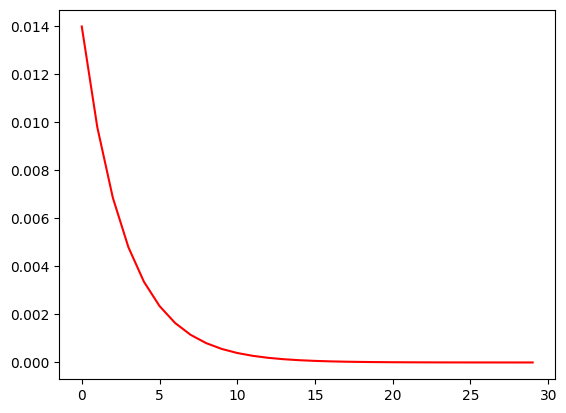

In [8]:
import matplotlib.pyplot as plt
lr_list = []

LR = 0.02
optimizer = torch.optim.Adam(unet.parameters(),lr = LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.9,patience=5,verbose=True,threshold_mode='rel',cooldown=0,min_lr=0,eps=1e-08)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
for epoch in range(30):
    optimizer.zero_grad()
    scheduler.step()
    
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
plt.plot(range(30),lr_list,color = 'r')

### **6、模型训练**
- **全文重点**

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
unet = U_Net()
unet.to(device)
model = unet

criterion = torch.nn.CrossEntropyLoss().to(device)
LR = 0.0001
optimizer = torch.optim.Adam(model.parameters(),lr = LR)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

epochs = 45
train_steps = 2500     #一个epoch训练的步长
val_steps = 400    #400
print_vallog = 100
print_log = 500  #打印日志的频数

save_acc = 0.7
OA = 0.0
Pr = 0.0
Rc = 0.0
F1 = 0.0
IoU = 0.0
loss_perprint = 0.0

val_OA = 0.0
val_Pr = 0.0
val_Rc = 0.0
val_F1 = 0.0
val_IoU = 0.0
val_loss_perprint = 0.0

train_loader = torch.utils.data.DataLoader(
        ImageDataset,
        batch_size=4,
        shuffle=True,
        pin_memory=True)
val_loader = torch.utils.data.DataLoader(
        ImageDataset,
        batch_size=2,
        shuffle=True,
        pin_memory=True)
for epoch in range(epochs):
    epoch_loss = 0.
    # scheduler.step()
    #====================================== Training ===========================================#
    model.train()
    torch.set_grad_enabled(True)
    for i, (images, labels) in enumerate(train_loader):
        images,labels = augment(images,labels)
        # pbar.update(1)
        if i == train_steps:
            OA = 0.0
            Pr = 0.0
            Rc = 0.0
            F1 = 0.0
            IoU = 0.0
            loss_perprint = 0.0
            break
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output_flat = output.view(output.size(0),-1)
        labels_flat = labels.view(labels.size(0),-1)
        loss = (criterion(output_flat,labels_flat))/images.size(0) # 计算损失
        # epoch_loss += loss.item()                 # 记录一个epoch有多少损失

        optimizer.zero_grad()                     # 清空梯度
        loss.backward()                           # 反向传播，求梯度
        optimizer.step()                          # 优化参数
        temp_OA,temp_Pr,temp_Rc,temp_F1,temp_IoU = eval_metrics(output,labels,device)
        if temp_Pr > save_acc:
            torch.save(model, "./model/lvdi/best_unet_model.pth")
            save_acc = temp_Pr
        OA += temp_OA
        Pr += temp_Pr
        Rc += temp_Rc
        F1 += temp_F1
        IoU += temp_IoU
        loss_perprint += loss.item() 
        if (i+1)%print_log == 0:
            #求每100张图片的平均精度评价
            print('[Train] 轮数: %d,步数: %d,OA: %.4f, Pr: %.4f, Rc: %.4f, F1: %.4f, IoU: %.4f, loss: %.4f'%(epoch,(i+1),round(OA/print_log,4),round(Pr/print_log,4),round(Rc/print_log,4),round(F1/print_log,4),round(IoU/print_log,4),round(loss_perprint/(print_log*256*256),4)))
            OA = 0.0
            Pr = 0.0
            Rc = 0.0
            F1 = 0.0
            IoU = 0.0
            loss_perprint = 0.0
    # pbar.close()
    #===================================== Validation ====================================#
    # model.eval()
    torch.no_grad()
    for i, (images, labels) in enumerate(val_loader):
        # pbar.update(1)
        if i == val_steps:
            val_OA = 0.0
            val_Pr = 0.0
            val_Rc = 0.0
            val_F1 = 0.0
            val_IoU = 0.0
            val_loss_perprint = 0.0
            break
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        output_flat = output.view(output.size(0),-1)
        labels_flat = labels.view(labels.size(0),-1)
        loss = criterion(output_flat,labels_flat) # 计算损失
 
        val_temp_OA,val_temp_Pr,val_temp_Rc,val_temp_F1,val_temp_IoU = eval_metrics(output,labels,device)
        val_OA += val_temp_OA
        val_Pr += val_temp_Pr
        val_Rc += val_temp_Rc
        val_F1 += val_temp_F1
        val_IoU += val_temp_IoU
        val_loss_perprint += loss.item()
        if (i+1)%print_vallog == 0:
            #求每张图片的平均精度评价
            print('[Val] OA: %.4f, Pr: %.4f, Rc: %.4f, F1: %.4f, IoU: %.4f, loss: %.4f'%(val_OA/print_vallog,val_Pr/print_vallog,val_Rc/print_vallog,val_F1/print_vallog,val_IoU/print_vallog,val_loss_perprint/(print_vallog*256*256)))
            val_OA = 0.0
            val_Pr = 0.0
            val_Rc = 0.0
            val_F1 = 0.0
            val_IoU = 0.0
    print('保存轮数: %d,步数: %d,模型成功'%(epoch,(i+1)))
    torch.save(model, "./model/lvdi/" + "epoch_" + str(epoch) + "_lastEpoch_unet_model.pth")